## Deep-Q Learning using Simple Feedfoward Neural Network

The solution crops the output pixel matrix to isolate the racing car and track for one, and isolates the sensor readers in second place.  The top part (track and car) and quantized to b/w and flatten out to a 1D vector.  The bottom part, i.e. the sensors output (steering, g, speed, abs) is analysed and the various sensors output and numerized.  A single feature vector is created by merging the two parts into one.  This approach is less fancy than using a CONV NN merged with a FFNN, but requies less process power and less episodes to get to a certain learning plateau.

As for the output of the nn, we have descrtized it into 9 possible actions: 7 steering (neutral, 3 right, 3 left) and 2 power, 50% brake or 33% gaz.  i.e. this means that the car cannot steer and power on at the same time.  Nor can it apply brake and gaz at the same time.  This reduces significantly the solution space. 

Enjoy,

Luc Prieur

In [1]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
import random
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.optimizers import SGD, RMSprop, Adam, Adamax
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Merge
from keras.utils import np_utils
from keras.models import load_model
import cv2

Using TensorFlow backend.


In [2]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

In [3]:
env = gym.make('CarRacing-v0')

[2017-08-30 12:45:02,904] Making new env: CarRacing-v0


In [4]:
env = wrappers.Monitor(env, 'monitor-folder', force=True)

[2017-08-30 12:45:03,105] Clearing 15 monitor files from previous run (because force=True was provided)


In [5]:
def transform(s):
#     cv2.imshow('original', s)
#     cv2.waitKey(1)

    # crop_img = img[200:400, 100:300] # Crop from x, y, w, h -> 100, 200, 300, 400
    # NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
    # bottom_black_bar is the section of the screen with steering, speed, abs and gyro information.
    # we crop off the digits on the right as they are illigible, even for ml.
    # since color is irrelavent, we grayscale it.
    bottom_black_bar = s[84:, 12:]
    img = cv2.cvtColor(bottom_black_bar, cv2.COLOR_RGB2GRAY)
    bottom_black_bar_bw = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1]
    bottom_black_bar_bw = cv2.resize(bottom_black_bar_bw, (84, 12), interpolation = cv2.INTER_NEAREST)
    
    # upper_field = observation[:84, :96] # this is the section of the screen that contains the track.
    upper_field = s[:84, 6:90] # we crop side of screen as they carry little information
    img = cv2.cvtColor(upper_field, cv2.COLOR_RGB2GRAY)
    upper_field_bw = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)[1]
    upper_field_bw = cv2.resize(upper_field_bw, (10, 10), interpolation = cv2.INTER_NEAREST) # re scaled to 7x7 pixels
#     cv2.imshow('video', upper_field_bw)
#     cv2.waitKey(1)
    upper_field_bw = upper_field_bw.astype('float')/255
        
    car_field = s[66:78, 43:53]
    img = cv2.cvtColor(car_field, cv2.COLOR_RGB2GRAY)
    car_field_bw = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)[1]

#     print(car_field_bw[:, 3].mean()/255, car_field_bw[:, 4].mean()/255, car_field_bw[:, 5].mean()/255, car_field_bw[:, 6].mean()/255)
    car_field_t = [car_field_bw[:, 3].mean()/255, car_field_bw[:, 4].mean()/255, car_field_bw[:, 5].mean()/255, car_field_bw[:, 6].mean()/255]
    
#     rotated_image = rotateImage(car_field_bw, 45)
#     cv2.imshow('video rotated', rotated_image)
#     cv2.waitKey(1)

    return bottom_black_bar_bw, upper_field_bw, car_field_t

In [6]:
# this function uses the bottom black bar of the screen and extracts steering setting, speed and gyro data
def compute_steering_speed_gyro_abs(a):
    right_steering = a[6, 36:46].mean()/255
    left_steering = a[6, 26:36].mean()/255
    steering = (right_steering - left_steering + 1.0)/2
    
    left_gyro = a[6, 46:60].mean()/255
    right_gyro = a[6, 60:76].mean()/255
    gyro = (right_gyro - left_gyro + 1.0)/2
    
    speed = a[:, 0][:-2].mean()/255
    abs1 = a[:, 6][:-2].mean()/255
    abs2 = a[:, 8][:-2].mean()/255
    abs3 = a[:, 10][:-2].mean()/255
    abs4 = a[:, 12][:-2].mean()/255
    
#     white = np.ones((round(speed * 100), 10))
#     black = np.zeros((round(100 - speed * 100), 10))
#     speed_display = np.concatenate((black, white))*255
        
#     cv2.imshow('sensors', speed_display)
#     cv2.waitKey(1)

    
    return [steering, speed, gyro, abs1, abs2, abs3, abs4]

In [7]:
vector_size = 10*10 + 7 + 4

In [8]:
def create_nn():
    if os.path.exists('race-car.h5'):
        return load_model('race-car.h5')
        
    model = Sequential()
    model.add(Dense(512, init='lecun_uniform', input_shape=(vector_size,)))# 7x7 + 3.  or 14x14 + 3
    model.add(Activation('relu'))

#     model.add(Dense(512, init='lecun_uniform'))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.3))

    model.add(Dense(11, init='lecun_uniform'))
    model.add(Activation('linear')) #linear output so we can have range of real-valued outputs

#     rms = RMSprop(lr=0.005)
#     sgd = SGD(lr=0.1, decay=0.0, momentum=0.0, nesterov=False)
# try "adam"
#     adam = Adam(lr=0.0005)
    adamax = Adamax() #Adamax(lr=0.001)
    model.compile(loss='mse', optimizer=adamax)
    model.summary()
    
    return model

In [9]:
class Model:
    def __init__(self, env):
        self.env = env
        self.model = create_nn()  # one feedforward nn for all actions.

    def predict(self, s):
        return self.model.predict(s.reshape(-1, vector_size), verbose=0)[0]

    def update(self, s, G):
        self.model.fit(s.reshape(-1, vector_size), np.array(G).reshape(-1, 11), nb_epoch=1, verbose=0)

    def sample_action(self, s, eps):
        qval = self.predict(s)
        if np.random.random() < eps:
            return random.randint(0, 10), qval
        else:
            return np.argmax(qval), qval

In [10]:
def convert_argmax_qval_to_env_action(output_value):
    # we reduce the action space to 15 values.  9 for steering, 6 for gaz/brake.
    # to reduce the action space, gaz and brake cannot be applied at the same time.
    # as well, steering input and gaz/brake cannot be applied at the same time.
    # similarly to real life drive, you brake/accelerate in straight line, you coast while sterring.
    
    gaz = 0.0
    brake = 0.0
    steering = 0.0
    
    # output value ranges from 0 to 10
    
    if output_value <= 8:
        # steering. brake and gaz are zero.
        output_value -= 4
        steering = float(output_value)/4
    elif output_value >= 9 and output_value <= 9:
        output_value -= 8
        gaz = float(output_value)/3 # 33% 
    elif output_value >= 10 and output_value <= 10:
        output_value -= 9
        brake = float(output_value)/2 # 50% brakes
    else:
        print("error")
        
    white = np.ones((round(brake * 100), 10))
    black = np.zeros((round(100 - brake * 100), 10))
    brake_display = np.concatenate((black, white))*255  
    
    white = np.ones((round(gaz * 100), 10))
    black = np.zeros((round(100 - gaz * 100), 10))
    gaz_display = np.concatenate((black, white))*255
        
    control_display = np.concatenate((brake_display, gaz_display), axis=1)

    cv2.imshow('controls', control_display)
    cv2.waitKey(1)
    
    return [steering, gaz, brake]

In [11]:
def play_one(env, model, eps, gamma):
    observation = env.reset()
    done = False
    full_reward_received = False
    totalreward = 0
    iters = 0
    while not done:
        a, b, c = transform(observation)
        state = np.concatenate((np.array([compute_steering_speed_gyro_abs(a)]).reshape(1,-1).flatten(), b.reshape(1,-1).flatten(), c), axis=0) # this is 3 + 7*7 size vector.  all scaled in range 0..1      
        argmax_qval, qval = model.sample_action(state, eps)
        prev_state = state
        action = convert_argmax_qval_to_env_action(argmax_qval)
        observation, reward, done, info = env.step(action)

        a, b, c = transform(observation)        
        state = np.concatenate((np.array([compute_steering_speed_gyro_abs(a)]).reshape(1,-1).flatten(), b.reshape(1,-1).flatten(), c), axis=0) # this is 3 + 7*7 size vector.  all scaled in range 0..1      
        
        # update the model
        # standard Q learning TD(0)
        next_qval = model.predict(state)
        G = reward + gamma*np.max(next_qval)
        y = qval[:]
        y[argmax_qval] = G
        model.update(prev_state, y)
        totalreward += reward
        iters += 1
        
        if iters > 1500:
            print("This episode is stuck")
            break
        
    return totalreward, iters


Track generation: 1262..1590 -> 328-tiles track


[2017-08-30 12:45:06,781] Starting new video recorder writing to C:\Users\lucpr\Documents\nn\rl\monitor-folder\openaigym.video.0.12248.video000000.mp4
[2017-08-30 12:46:13,405] Starting new video recorder writing to C:\Users\lucpr\Documents\nn\rl\monitor-folder\openaigym.video.0.12248.video000001.mp4


episode: 0 iters 1000 total reward: 34.55657492355014 eps: 0.0166574151163 avg reward (last 100): 34.5565749236
Track generation: 1191..1493 -> 302-tiles track
episode: 1 iters 1000 total reward: 232.22591362126767 eps: 0.0166481789553 avg reward (last 100): 133.391244272
Track generation: 1148..1438 -> 290-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1271..1594 -> 323-tiles track
episode: 2 iters 1000 total reward: 182.60869565217476 eps: 0.016638958141 avg reward (last 100): 149.797061399
Track generation: 1384..1734 -> 350-tiles track
episode: 3 iters 1000 total reward: 172.20630372493304 eps: 0.0166297526309 avg reward (last 100): 155.39937198
Track generation: 1067..1340 -> 273-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1183..1483 -> 300-tiles track
episode: 4 iters 1000 total reward: 308.0267558528279 eps: 0.0166205623829 avg reward (last 100): 185.924848755
Track g

[2017-08-30 12:50:17,243] Starting new video recorder writing to C:\Users\lucpr\Documents\nn\rl\monitor-folder\openaigym.video.0.12248.video000008.mp4


episode: 7 iters 1000 total reward: 32.61648745519621 eps: 0.01659308279 avg reward (last 100): 176.795242919
Track generation: 1100..1379 -> 279-tiles track
episode: 8 iters 1000 total reward: 439.5683453237243 eps: 0.0165839531702 avg reward (last 100): 205.992254297
Track generation: 1175..1472 -> 297-tiles track
episode: 9 iters 1000 total reward: 349.324324324327 eps: 0.0165748386033 avg reward (last 100): 220.3254613
Track generation: 1121..1405 -> 284-tiles track
episode: 10 iters 1000 total reward: 670.3180212013995 eps: 0.0165657390481 avg reward (last 100): 261.233875836
Track generation: 1191..1493 -> 302-tiles track
episode: 11 iters 1000 total reward: 255.48172757474578 eps: 0.0165566544633 avg reward (last 100): 260.754530148
Track generation: 1183..1483 -> 300-tiles track
episode: 12 iters 1000 total reward: 465.2173913043428 eps: 0.016547584808 avg reward (last 100): 276.482442545
Track generation: 1054..1321 -> 267-tiles track
episode: 13 iters 1000 total reward: 257.1

[2017-08-30 13:00:51,352] Starting new video recorder writing to C:\Users\lucpr\Documents\nn\rl\monitor-folder\openaigym.video.0.12248.video000027.mp4


episode: 26 iters 1000 total reward: 481.08108108107143 eps: 0.0164221546361 avg reward (last 100): 313.600543874
Track generation: 1115..1412 -> 297-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1071..1343 -> 272-tiles track
episode: 27 iters 1000 total reward: 483.0258302582919 eps: 0.0164133041075 avg reward (last 100): 319.651446959
Track generation: 1155..1448 -> 293-tiles track
episode: 28 iters 1000 total reward: 533.5616438356016 eps: 0.0164044678731 avg reward (last 100): 327.027660644
Track generation: 1295..1623 -> 328-tiles track
episode: 29 iters 1000 total reward: 169.1131498470986 eps: 0.0163956458946 avg reward (last 100): 321.763843618
Track generation: 1001..1261 -> 260-tiles track
episode: 30 iters 1000 total reward: 347.8764478764433 eps: 0.0163868381336 avg reward (last 100): 322.606185691
Track generation: 1256..1581 -> 325-tiles track
episode: 31 iters 1000 total reward: 412.34567901234556 eps: 0.01637804455

[2017-08-30 13:21:13,059] Starting new video recorder writing to C:\Users\lucpr\Documents\nn\rl\monitor-folder\openaigym.video.0.12248.video000064.mp4


episode: 63 iters 1000 total reward: 424.53987730060754 eps: 0.01610391566 avg reward (last 100): 336.277601586
Track generation: 1187..1488 -> 301-tiles track
episode: 64 iters 1000 total reward: 539.999999999983 eps: 0.0160955694995 avg reward (last 100): 339.411792331
Track generation: 1076..1349 -> 273-tiles track
episode: 65 iters 1000 total reward: 403.6764705882202 eps: 0.0160872363022 avg reward (last 100): 340.385499577
Track generation: 1370..1724 -> 354-tiles track
episode: 66 iters 1000 total reward: 208.78186968838875 eps: 0.0160789160346 avg reward (last 100): 338.421266295
Track generation: 1111..1393 -> 282-tiles track
episode: 67 iters 1000 total reward: 213.1672597864786 eps: 0.0160706086633 avg reward (last 100): 336.579295611
Track generation: 1073..1345 -> 272-tiles track
episode: 68 iters 1000 total reward: 446.1254612545974 eps: 0.0160623141551 avg reward (last 100): 338.1669212
Track generation: 1253..1570 -> 317-tiles track
episode: 69 iters 1000 total reward: 

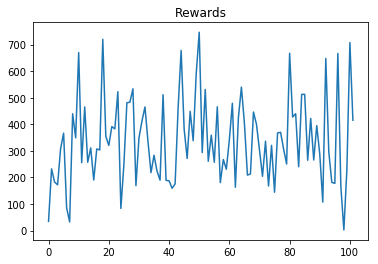

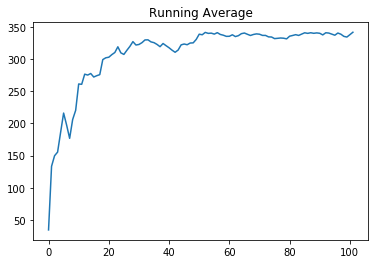

In [12]:
# from IPython.display import clear_output

model = Model(env)
gamma = 0.99

N = 102
totalrewards = np.empty(N)
costs = np.empty(N)
for n in range(N):
    eps = 0.5/np.sqrt(n+1 + 900) 
    totalreward, iters = play_one(env, model, eps, gamma)
    totalrewards[n] = totalreward
    if n % 1 == 0:
      print("episode:", n, "iters", iters, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())        
    if n % 10 == 0:
        model.model.save('race-car.h5')

print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards)

In [13]:
model.model.save('race-car.h5')

In [14]:
env.close()

[2017-08-30 13:41:42,784] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\lucpr\\Documents\\nn\\rl\\monitor-folder')


### ---------------------------------------